In [1]:
from models.model_v1 import *
from data.midi_preprocessing import *
from utils.dataset_loader import MaestroV3DataModule

C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\pretty_midi\instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Callback to track the loss of the minmax game.
class LossTracker(L.Callback):
    def __init__(self):
        self.g_losses = []
        self.d_losses = []

    #def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
    def on_train_epoch_end(self, trainer, pl_module):
        g_loss = trainer.callback_metrics.get("g_loss")
        d_loss = trainer.callback_metrics.get("d_loss")
        self.g_losses.append(g_loss.item())
        self.d_losses.append(d_loss.item())

    def plot(self):
        display.clear_output(wait=True)
        plt.plot(self.g_losses, label="Generator Loss")
        plt.plot(self.d_losses, label="Discriminator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Losses")
        plt.legend()
        plt.grid(True)
        plt.show()

In [3]:
# Create the GAN.
model = GAN(
    lr=4e-5,
    latent_dim=100,
    gen_updates=3,
    dis_updates=1,
    minibatch_B=5,
    minibatch_C=8,
    lambda_1=5,
    lambda_2=0.3,
    batch_size=16
)

# Dataset.
data_file_path = "data/preprocessed/maestro-v3.0.0/dataset1/13K_dataset.h5"
dm = MaestroV3DataModule(data_file_path)

# LossTracker.
loss_tracker = LossTracker()

# Define the trainer.
trainer = L.Trainer(
    default_root_dir="outputs/checkpoints/",
    #enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=3,
    callbacks=[loss_tracker]
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\kriptos\miniconda3\envs\jupyter_env\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


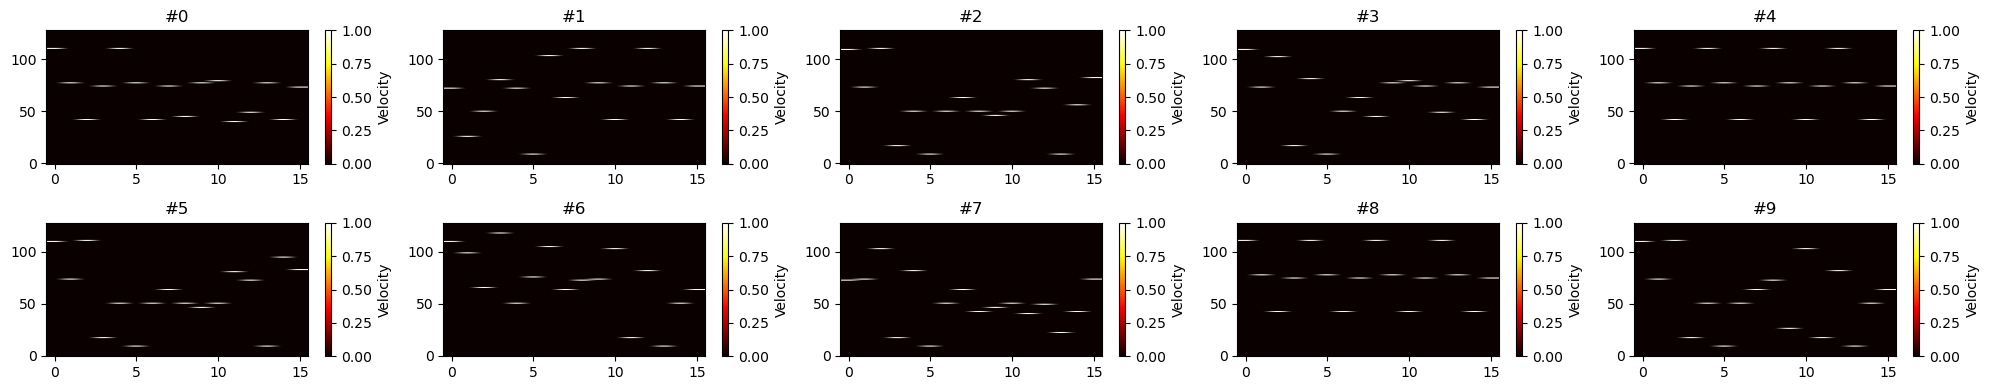

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████████████████████████████| 423/423 [00:38<00:00, 11.03it/s, v_num=0, d_loss=1.390, g_loss=0.767]


In [4]:
trainer.fit(model, dm)

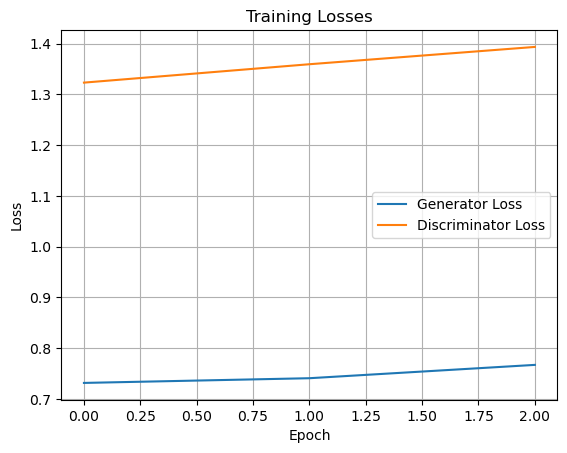

In [5]:
loss_tracker.plot()

In [15]:

model = GAN.load_from_checkpoint("outputs/checkpoints/lightning_logs/version_0/checkpoints/epoch=2-step=5076.ckpt")

# Set model in evaluation.
model.eval()

# Generate a sample.
z_lst = []
for _ in range(3):
    noise = torch.randn(1, 100)
    #print(noise)
    z_lst.append(noise)
hat_y = []
for z in z_lst:
    hat_y.append(model(z))
#print((hat_y>0).sum())
#hat_y = hat_y.squeeze(0, 1)
#print(hat_y.shape)
#print(hat_y)
#print((hat_y > 0).sum())

(128, 16)


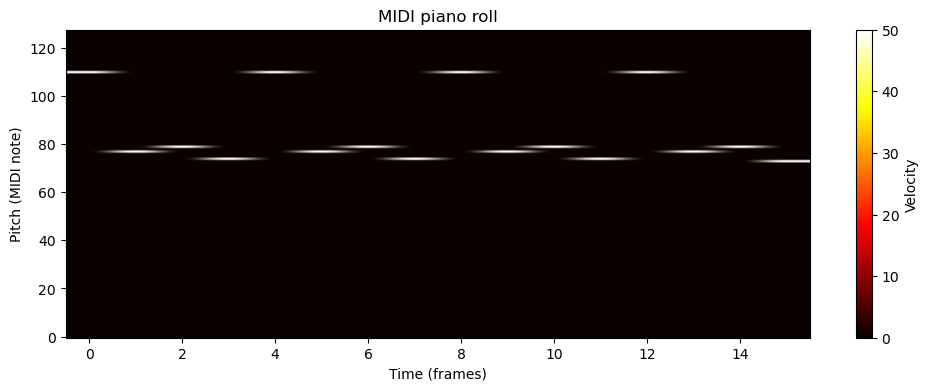

(128, 16)


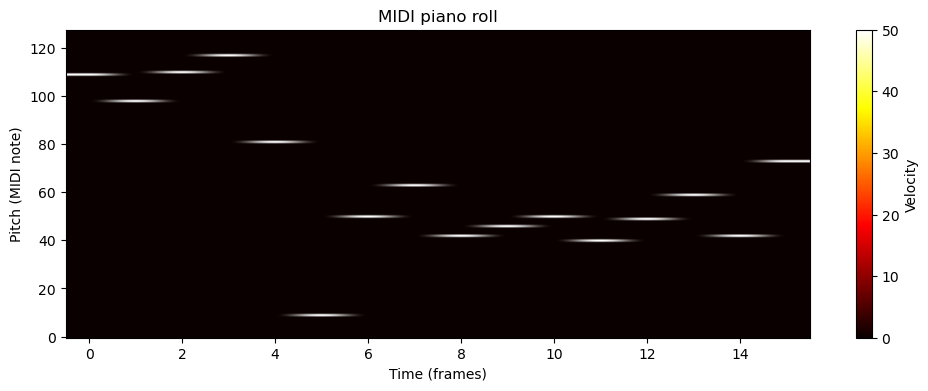

(128, 16)


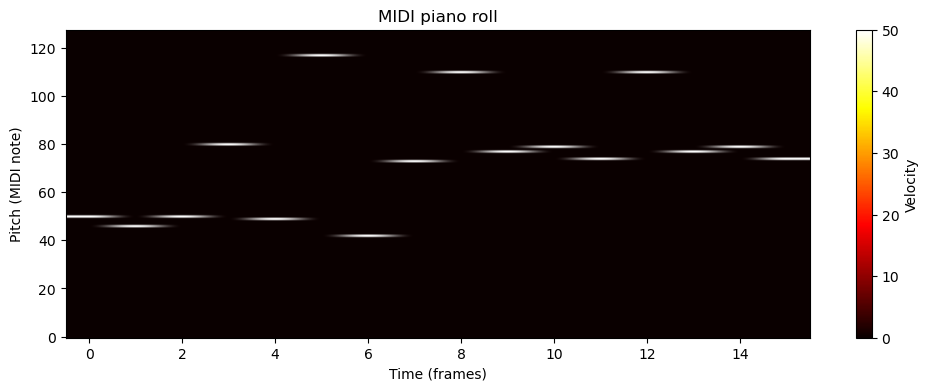

In [16]:
pr_lst = []
for i, y in enumerate(hat_y):
    # From tensor to numpy.
    y = y.squeeze(0, 1)
    pr = y.detach().numpy()
    pr *= 50
    print(pr.shape)

    # Print piano roll.
    show_piano_roll(pr)
    midi_file = piano_roll_to_pretty_midi(pr, fs=8)

    # Save midi to file.
    filename = "output_ex" + str(i) + ".midi"
    midi_file.write(filename)
    pr_lst.append(pr)

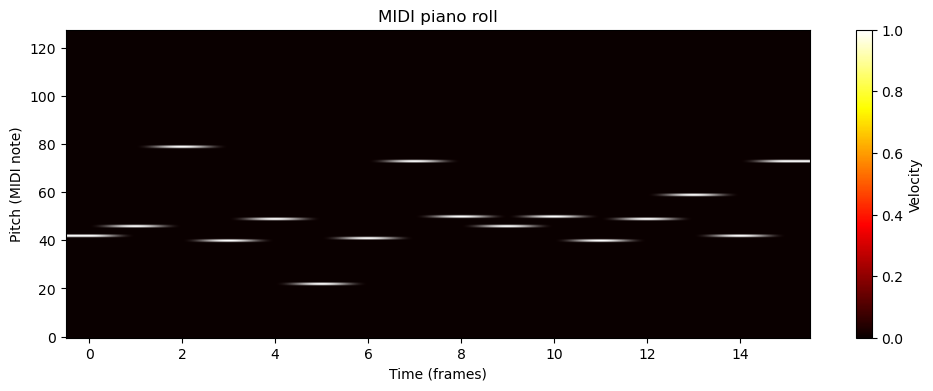

tensor(0)

In [9]:
tensor = model(z_lst[2])
_, max_indices = torch.max(tensor, dim=2, keepdim=True)
#print(max_indices)
show_piano_roll(tensor.squeeze(0,1).detach())
(tensor.squeeze(0,1) > 1).sum()

#y_hard = torch.zeros_like(tensor)
#y_hard = y_hard.scatter(dim=2, index=max_indices, value=1.0)
#out = (y_hard - tensor).detach() + tensor
#out = out.squeeze(0, 1)
#(out > 0).sum()
#show_piano_roll(out.detach())

In [10]:
def ascolta_midi(file_midi: str):
    """
    Riproduce un file MIDI utilizzando pygame.

    Args:
        file_midi (str): Il percorso del file .mid da riprodurre.
    """
    try:
        # Inizializza il mixer di pygame
        # I valori sono standard: frequenza, bit, canali, dimensione del buffer
        pygame.mixer.init(44100, -16, 2, 512)

        pygame.init()

        print(f"🎵 Riproduzione di '{file_midi}'...")

        # Carica e riproduci il file MIDI
        pygame.mixer.music.load(file_midi)
        pygame.mixer.music.play()

        # Attendi che la musica finisca
        # Mantiene lo script attivo finché la musica è in riproduzione
        while pygame.mixer.music.get_busy():
            time.sleep(0.1)

    except pygame.error as e:
        print(f"Errore di pygame: {e}")
        print("Assicurati che il file MIDI sia valido e che i driver audio funzionino.")
    except FileNotFoundError:
        print(f"Errore: File non trovato all'indirizzo '{file_midi}'")
    finally:
        # Pulisci e chiudi pygame per liberare le risorse
        if pygame.get_init():
            pygame.mixer.music.stop()
            pygame.mixer.quit()
            pygame.quit()
        print("Riproduzione terminata.")

In [11]:
ascolta_midi("ouput_ex.midi")

NameError: name 'pygame' is not defined

In [12]:
# Istanzia il modello
model_to_train = SimpleClassifier(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, learning_rate=LEARNING_RATE)

# Crea una cartella per i checkpoint se non esiste
checkpoint_dir = "my_training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback per salvare il checkpoint finale
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="my_model-{epoch:02d}",
    save_last=True # Salva l'ultimo checkpoint al termine
)

# Trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback],
    logger=False # Per questo esempio, disabilitiamo il logger per semplicità
)

print("\n--- Inizio del training ---")
trainer.fit(model_to_train, dataloader)
print("--- Training completato ---")

# Trova il percorso dell'ultimo checkpoint salvato
last_checkpoint_path = checkpoint_callback.last_model_path
print(f"\nCheckpoint salvato in: {last_checkpoint_path}")

# 4. Caricamento del Modello e degli Iperparametri dal Checkpoint

print("\n--- Caricamento del modello dal checkpoint ---")

# Metodo 1: Caricare il checkpoint raw e accedere agli iperparametri
# Questo è utile se vuoi solo leggere gli iperparametri senza istanziare subito il modello
checkpoint_dict = torch.load(last_checkpoint_path, map_location=lambda storage, loc: storage)

print(f"Iperparametri salvati: {checkpoint_dict.get('hyper_parameters', 'Chiave non trovata, prova "hparams"')}")
# Le versioni più recenti di Lightning usano 'hparams', le vecchie 'hyper_parameters'
# Quindi potresti voler usare .get('hparams', checkpoint_dict.get('hyper_parameters')) o controllare

print(f"Iperparametri specifici: Input Dim={checkpoint_dict['hyper_parameters']['input_dim']}, "
      f"Hidden Dim={checkpoint_dict['hyper_parameters']['hidden_dim']}, "
      f"Learning Rate={checkpoint_dict['hyper_parameters']['learning_rate']}")


# Metodo 2 (Raccomandato): Caricare direttamente il LightningModule dal checkpoint
# Questo re-instanza il tuo LightningModule con gli iperparametri salvati
# e carica i pesi del modello.
loaded_model = SimpleClassifier.load_from_checkpoint(last_checkpoint_path)

print(f"\nModello caricato con successo. Iperparametri recuperati da .hparams: {loaded_model.hparams}")
print(f"Tipo di Learning Rate nel modello caricato: {loaded_model.hparams.learning_rate}")

# Puoi accedere ai pesi del modello caricato
# print(loaded_model.state_dict())

# Ora puoi usare 'loaded_model' per inferenza o continuare il training
loaded_model.eval() # Imposta il modello in modalità valutazione
sample_input = torch.randn(1, INPUT_DIM)
output = loaded_model(sample_input)
print(f"\nOutput di esempio dal modello caricato: {output.item():.4f}")

# Simulare un nuovo training partendo dal checkpoint (opzionale)
# new_trainer = pl.Trainer(max_epochs=10, logger=False) # Continua per altre 5 epoche (tot 10)
# new_trainer.fit(loaded_model, dataloader, ckpt_path=last_checkpoint_path) # Riprende dal checkpoint

# Pulizia (opzionale)
# import shutil
# if os.path.exists(checkpoint_dir):
#     shutil.rmtree(checkpoint_dir)

SyntaxError: f-string: unterminated string (1271168132.py, line 38)